In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle
import numpy as np
import os
import sys

In [14]:
sys.path.append('../src/')

In [15]:
from modules import helpers as hp
from modules import mammoscan as ms

In [16]:
plt.style.use('dark_background') # comment or delete it for light background

In [17]:
mammo = pd.read_table('../scan_file_data.txt', delimiter='\s', engine='python')

In [18]:
# rename the class column to avoid conflicts with the class keyword in python
mammo.columns = ['refnum', 'bg', 'ab_class', 'severity', 'x', 'y', 'radius']

<AxesSubplot:>

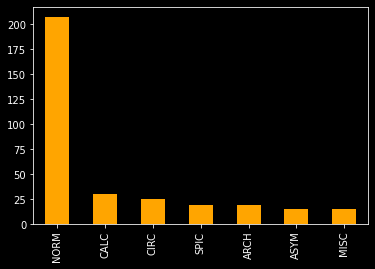

In [19]:
mammo.ab_class.value_counts().plot(kind='bar', color='orange')

<AxesSubplot:>

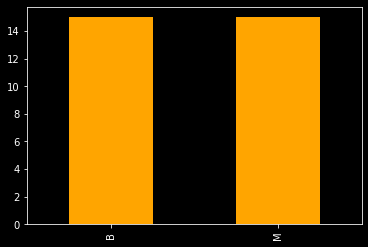

In [12]:
mammo.loc[mammo['ab_class'] == 'CALC'].severity.value_counts().plot(kind='bar', color='orange')

<AxesSubplot:>

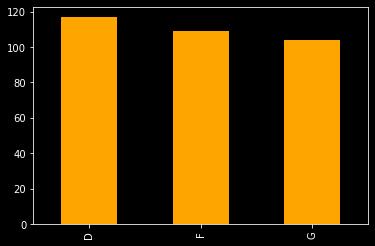

In [9]:
mammo.bg.value_counts().plot(kind='bar', color='orange')

In [10]:
mammo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   refnum    330 non-null    object 
 1   bg        330 non-null    object 
 2   ab_class  330 non-null    object 
 3   severity  123 non-null    object 
 4   x         122 non-null    object 
 5   y         122 non-null    object 
 6   radius    119 non-null    float64
dtypes: float64(1), object(6)
memory usage: 18.2+ KB


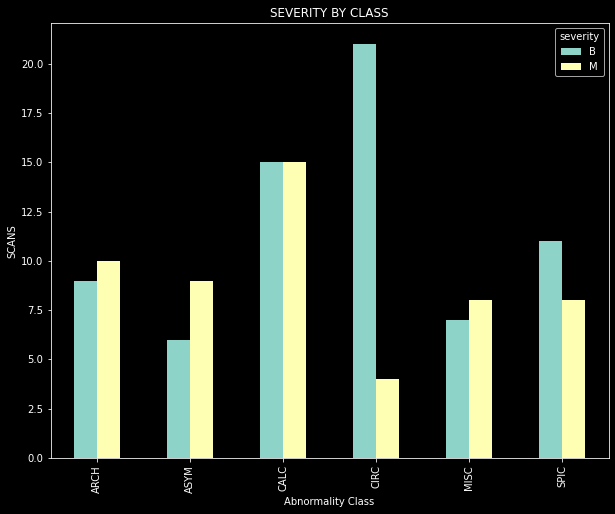

In [11]:
mx = mammo.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                                   figsize=(10, 8), 
                                                                   xlabel='Abnormality Class', 
                                                                   ylabel='SCANS',
                                                                   title='SEVERITY BY CLASS')


In [12]:
ab_sev = mammo.groupby(['ab_class', 'severity']).size()

In [13]:
ab_sev = mammo.groupby('ab_class').severity.value_counts(normalize=True)
ab_sev

ab_class  severity
ARCH      M           0.526316
          B           0.473684
ASYM      M           0.600000
          B           0.400000
CALC      B           0.500000
          M           0.500000
CIRC      B           0.840000
          M           0.160000
MISC      M           0.533333
          B           0.466667
SPIC      B           0.578947
          M           0.421053
Name: severity, dtype: float64

<ipython-input-14-5fbc8788e17a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.2%}' for x in vals]);


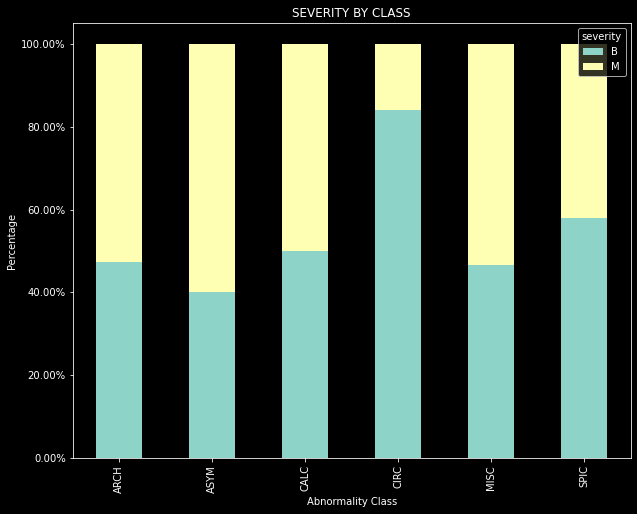

In [14]:
ax = ab_sev.unstack().plot(kind='bar', 
                      stacked=True, 
                      figsize=(10, 8), 
                      xlabel='Abnormality Class', 
                      ylabel='Percentage',
                      title='SEVERITY BY CLASS');

# manipulate
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2%}' for x in vals]);

In [15]:
# get indices of the norm class only
norms = lambda x: x == 'NORM'
mammo.severity = mammo.severity.fillna('A')

In [21]:
from pathlib import Path
import re

INITIALLY REMOVE ONLY THE SCANS WITHOUT INVALID X ENTRY *NOTE

In [20]:
test_df = mammo.copy()

In [18]:
test_df

,refnum,bg,ab_class,severity,x,y,radius
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb003,D,NORM,A,None,None,NaN
3,mdb004,D,NORM,A,None,None,NaN
4,mdb005,F,CIRC,B,477,133,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,A,None,None,NaN
326,mdb319,D,NORM,A,None,None,NaN
327,mdb320,D,NORM,A,None,None,NaN
328,mdb321,D,NORM,A,None,None,NaN


In [22]:
test_df.drop_duplicates(subset='refnum', keep='first', inplace=True)

In [23]:
test_df.set_index(keys='refnum', drop=True, inplace=True)

In [24]:
test_df.index;

In [25]:
clean_df = hp.clean_ds_files(test_df)

In [26]:
clean_df.head()

,bg,ab_class,severity,x,y,radius
refnum,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,None,NaN,NaN,NaN
mdb004,D,NORM,None,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0


In [27]:
# save clean to file
clean_df.to_csv('test_df.csv')

In [28]:
type(clean_df.loc['mdb005'])

pandas.core.series.Series

In [29]:
scan_info = clean_df.loc['mdb003'].copy() # need to ensure we get a deep copy of the Series to avoid changing a value in it and keeping the reference
scan_info

bg             D
ab_class    NORM
severity    None
x            NaN
y            NaN
radius       NaN
Name: mdb003, dtype: object

In [30]:
from PIL import Image

In [31]:
test_img = Image.open('../all-mias/mdb003.pgm')

In [32]:
test = ms.MammoScan(test_img, scan_info)

In [33]:
test.pixel_matrix.shape

(1024, 1024)

504.0, 512.0, 48.0


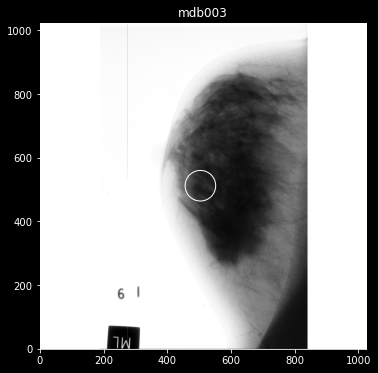

In [34]:
test.plot()

In [32]:
transformed = test.transformations
transformed

{0: {'rotated': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC70395C40>,
  'mirr_lr': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC703B99D0>,
  'mirr_tp': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC703B9250>},
 90: {'rotated': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC700E0490>,
  'mirr_lr': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC6FC02DF0>,
  'mirr_tp': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC700E0430>},
 180: {'rotated': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC703B95B0>,
  'mirr_lr': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC6FB01DF0>,
  'mirr_tp': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC6FB01E50>},
 270: {'rotated': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC6C03D040>,
  'mirr_lr': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC6C03DA30>,
  'mirr_tp': <PIL.Image.Image image mode=L size=48x48 at 0x7FEC6C03D970>}}

In [33]:
'''

for angle, imgs in transformed.items():
    for transf, img in imgs.items():
        print(f'{angle}, {transf}')
        print(np.asarray(img))
        display(img)
        
'''        
        
# 90 degrees left-right == 270 degree top-bottom
# 0 degrees left-right == 180 top-bottom
# drop duplicates???

"\n\nfor angle, imgs in transformed.items():\n    for transf, img in imgs.items():\n        print(f'{angle}, {transf}')\n        print(np.asarray(img))\n        display(img)\n        \n"

In [35]:
scans_filenames_dic = hp.create_scan_filenames_dic('../all-mias/')

### Check the quality of crops

mdb001
535.0, 599.0, 197.0
mdb002
522.0, 744.0, 69.0
mdb003
507.0, 523.0, 48.0
mdb004
501.0, 523.0, 48.0
mdb005
477.0, 891.0, 30.0
mdb006
506.0, 515.0, 48.0
mdb007
505.0, 518.0, 48.0
mdb008
503.0, 514.0, 48.0
mdb009
500.0, 524.0, 48.0
mdb010
525.0, 599.0, 33.0
mdb011
510.0, 515.0, 48.0
mdb012
471.0, 566.0, 40.0


../src/modules/mammoscan.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


mdb013
667.0, 659.0, 31.0
mdb014
509.0, 514.0, 48.0
mdb015
595.0, 160.0, 68.0
mdb016
507.0, 515.0, 48.0
mdb017
547.0, 451.0, 48.0
mdb018
509.0, 520.0, 48.0
mdb019
653.0, 547.0, 49.0


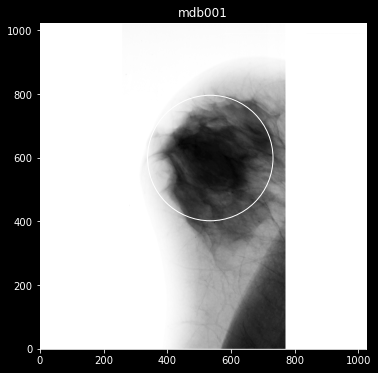

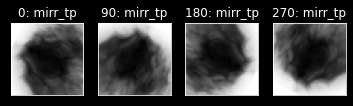

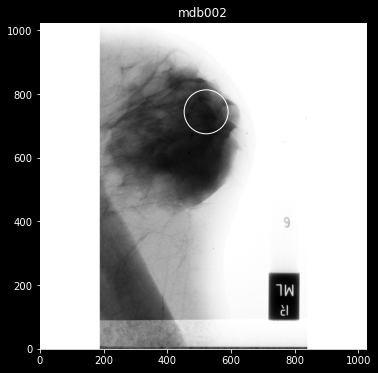

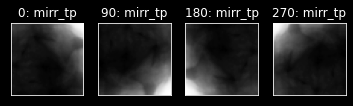

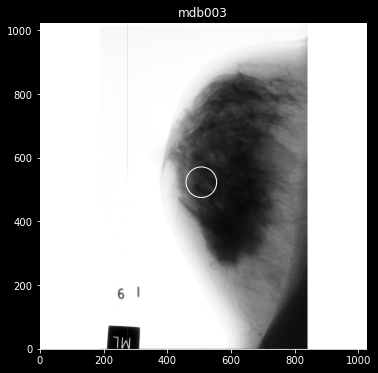

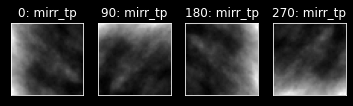

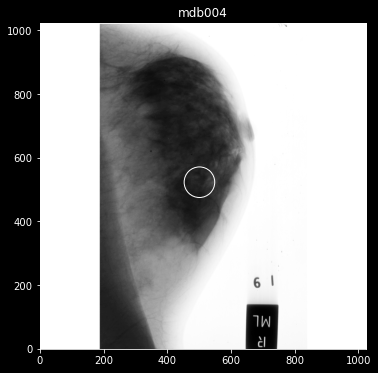

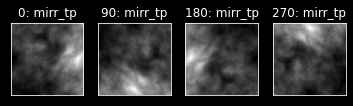

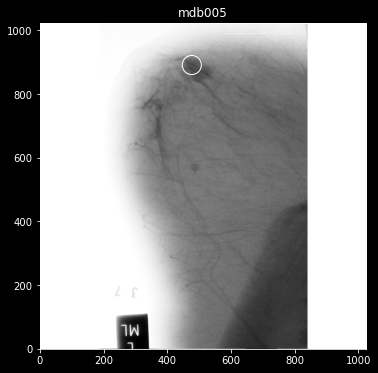

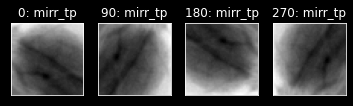

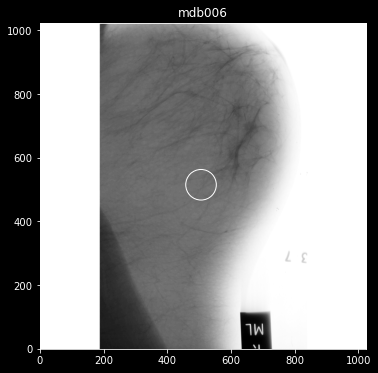

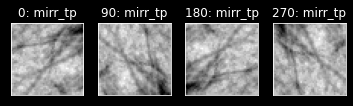

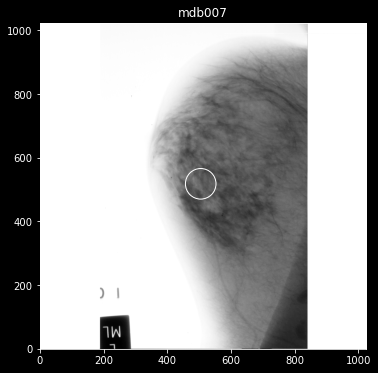

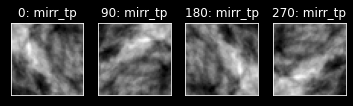

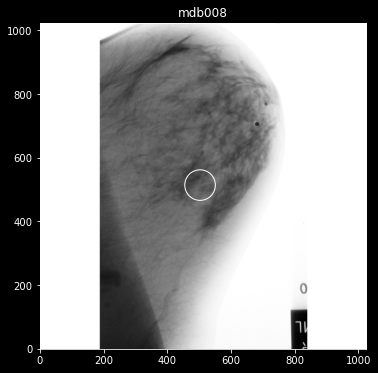

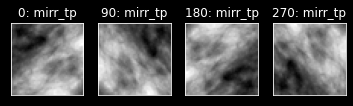

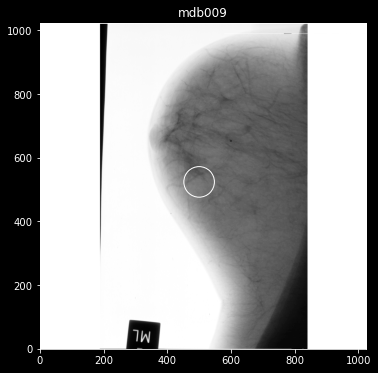

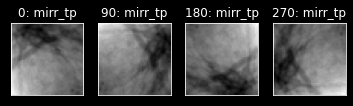

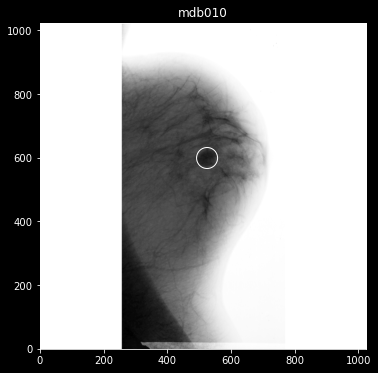

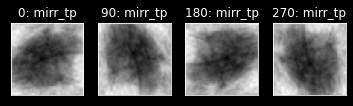

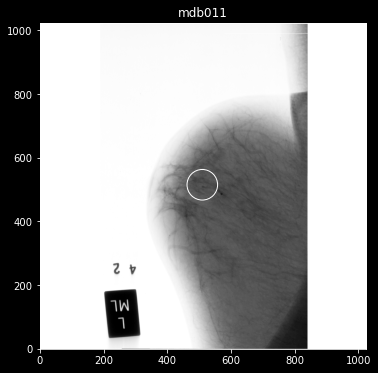

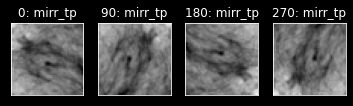

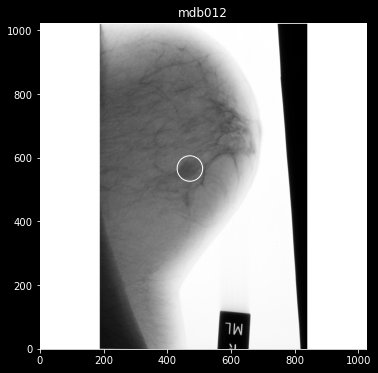

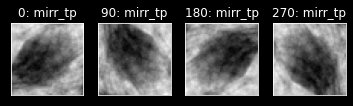

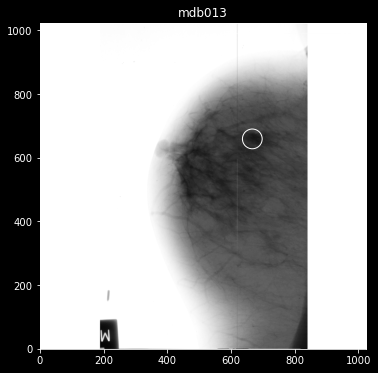

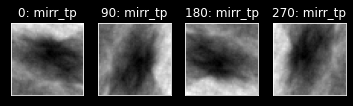

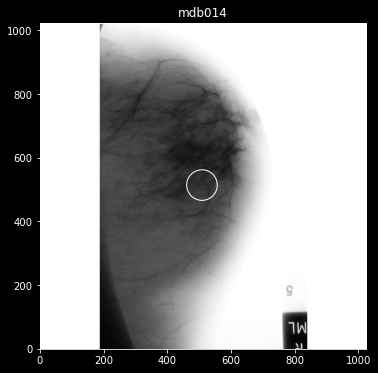

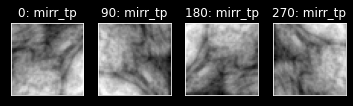

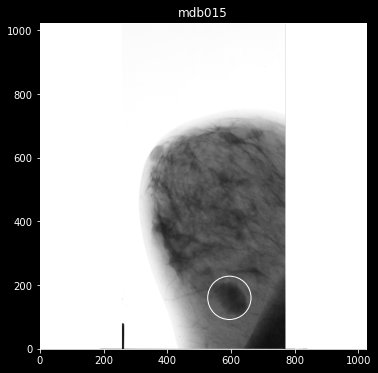

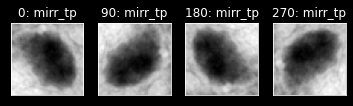

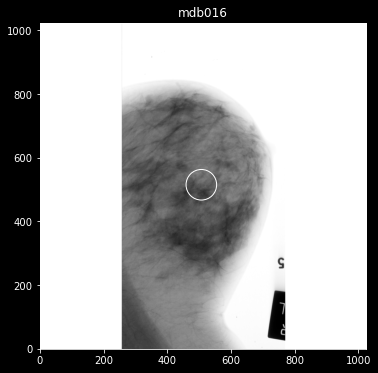

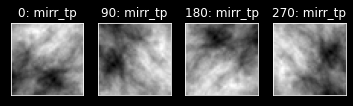

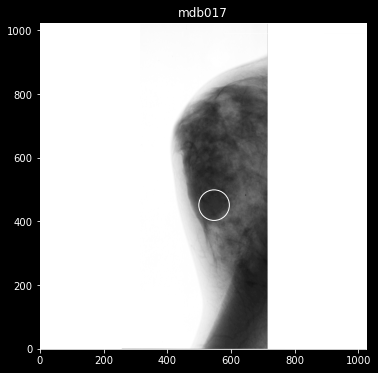

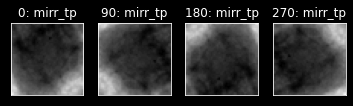

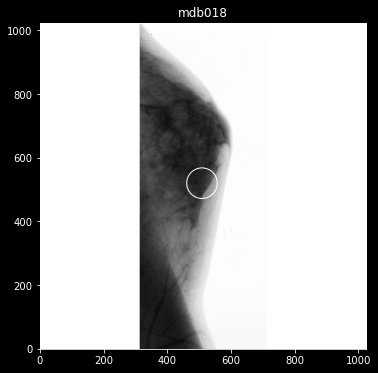

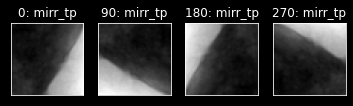

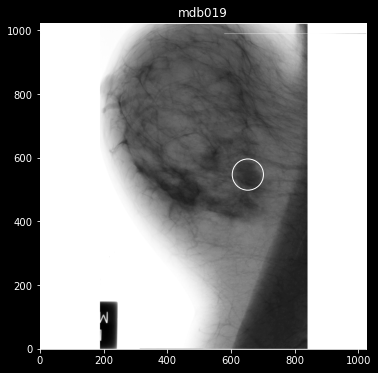

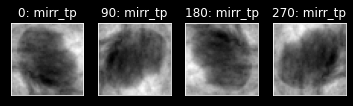

In [35]:
counter = 0
for scan_name, filename in scans_filenames_dic.items():
        # create image and scan info objects
        try:
            scan = Image.open(filename)
        except FileNotFoundError as fnf:
            print({fnf})
            
        scan_info = clean_df.loc[scan_name].copy()
        print(scan_info.name)
        # create the MammoScan object
        m_scan = ms.MammoScan(scan, scan_info)
        
        m_scan.plot()
        # get the transformations
        transf_scans = m_scan.transformations
        
        figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(6, 6))
        
        for item in zip(axes.ravel(), transf_scans.items()):
            axes, images = item
            angle, transfs = images
            for transf, img in transfs.items():
                axes.imshow(img, cmap=plt.cm.gray_r)
                axes.set_xticks([]) # remove x-axis tick marks
                axes.set_yticks([]) # remove y-axis tick marks
                axes.set_title(f'{angle}: {transf}')
        # plt.tight_layout
        counter+= 1
        if counter == 19:
            break


In [37]:
test_sub = hp.save_subsamples(scans_filenames_dic, clean_df)

In [38]:
test_sub

,ab_class,bg,severity,subsample_path
mdb001_0_rotated,CIRC,G,B,../subsamples/mdb001_0_rotated.png
mdb001_0_mirr_lr,CIRC,G,B,../subsamples/mdb001_0_mirr_lr.png
mdb001_0_mirr_tp,CIRC,G,B,../subsamples/mdb001_0_mirr_tp.png
mdb001_90_rotated,CIRC,G,B,../subsamples/mdb001_90_rotated.png
mdb001_90_mirr_lr,CIRC,G,B,../subsamples/mdb001_90_mirr_lr.png
...,...,...,...,...
mdb322_180_mirr_lr,NORM,D,None,../subsamples/mdb322_180_mirr_lr.png
mdb322_180_mirr_tp,NORM,D,None,../subsamples/mdb322_180_mirr_tp.png
mdb322_270_rotated,NORM,D,None,../subsamples/mdb322_270_rotated.png
mdb322_270_mirr_lr,NORM,D,None,../subsamples/mdb322_270_mirr_lr.png


### TRAIN AND EVALUATE MODEL FOR THE MASSES

In [223]:
# TRAIN AND TEST DATA FOR THE MASSES
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [224]:
masses = test_sub[(test_sub.ab_class == 'CIRC') | 
                  (test_sub.ab_class == 'SPIC') | 
                  (test_sub.ab_class == 'MISC')]

In [225]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    rotation_range=180,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    validation_split=.2)

In [226]:
train_data = data_generator.flow_from_dataframe(masses, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(masses, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 538 validated image filenames belonging to 2 classes.
Found 134 validated image filenames belonging to 2 classes.


In [227]:
# create neural network
from tensorflow.keras.models import Sequential

In [228]:
cnn_mass = Sequential()

In [229]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [230]:
# add layers
cnn_mass.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [231]:
# Add a Pooling Layer
cnn_mass.add(MaxPooling2D(pool_size=(2, 2)))

In [232]:
cnn_mass.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [233]:
cnn_mass.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [234]:
cnn_mass.add(Flatten())

#### Add dense layer to reduce the number of features

In [235]:
from tensorflow.keras.layers import Dropout


In [236]:
cnn_mass.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [237]:
cnn_mass.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [238]:
cnn_mass.add(Dense(units=2, activation='softmax')) # 2 units - B/ M

In [239]:
cnn_mass.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 5184)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)             

#### Visualise the Model's Structure

In [240]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

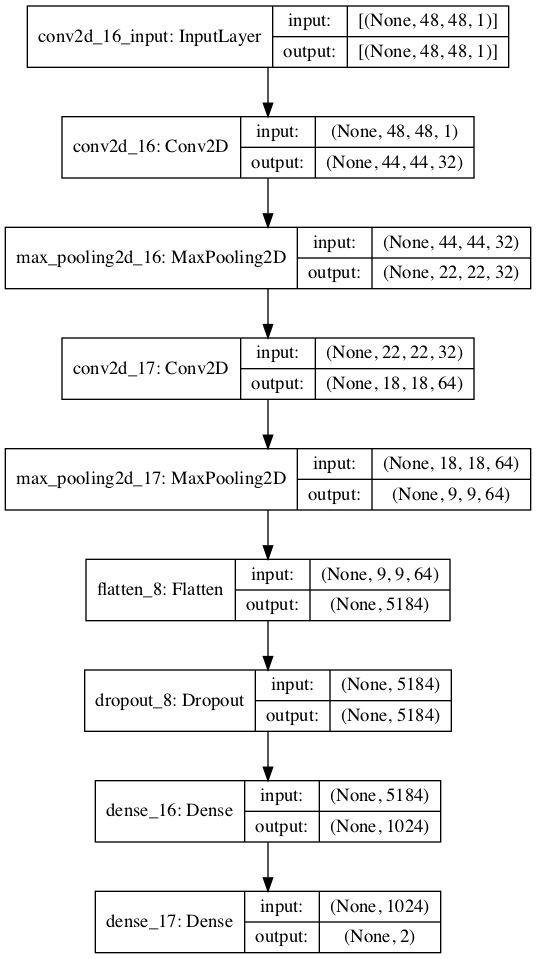

In [241]:
plot_model(cnn_mass, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [242]:
cnn_mass.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

### Training and Evaluating the Model

In [243]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [244]:
test_data.batch_size

32

In [245]:
cnn_mass.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
17/17 [==============================] - 2s 97ms/step - loss: 119.9800 - accuracy: 0.5110 - val_loss: 0.6262 - val_accuracy: 0.7761
Epoch 2/100
17/17 [==============================] - 1s 83ms/step - loss: 0.6966 - accuracy: 0.5586 - val_loss: 0.6897 - val_accuracy: 0.8731
Epoch 3/100
17/17 [==============================] - 1s 84ms/step - loss: 0.7010 - accuracy: 0.5964 - val_loss: 0.6769 - val_accuracy: 0.8806
Epoch 4/100
17/17 [==============================] - 1s 86ms/step - loss: 0.6844 - accuracy: 0.6161 - val_loss: 0.6658 - val_accuracy: 0.8731
Epoch 5/100
17/17 [==============================] - 1s 85ms/step - loss: 0.6911 - accuracy: 0.5988 - val_loss: 0.6481 - val_accuracy: 0.8881
Epoch 6/100
17/17 [==============================] - 1s 82ms/step - loss: 0.6899 - accuracy: 0.5907 - val_loss: 0.6419 - val_accuracy: 0.8881


#### Making predictions

In [246]:
y_pred = cnn_mass.predict(test_data)

In [248]:
y_pred[0]

array([0.62718403, 0.37281603], dtype=float32)

In [251]:
test_data.class_indices

{'B': 0, 'M': 1}

In [257]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [258]:
from sklearn.metrics import confusion_matrix, classification_report

In [259]:
confusion_matrix(expected, predicted)

array([[101,  21],
       [ 11,   1]])

In [260]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       122
           1       0.05      0.08      0.06        12

    accuracy                           0.76       134
   macro avg       0.47      0.46      0.46       134
weighted avg       0.83      0.76      0.79       134



### TRAIN AND EVALUATE MODEL FOR CALCIFICATIONS

In [39]:
# TRAIN AND TEST DATA FOR THE MASSES
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [40]:
calcifications = test_sub[(test_sub.ab_class == 'CALC')]

In [81]:
from sklearn.model_selection import train_test_split

In [93]:
X_train, X_test = train_test_split(calcifications, 
                                   test_size=.25, 
                                   random_state=42, 
                                   stratify=calcifications.severity)

In [94]:
X_train.groupby(['severity']).count()

,ab_class,bg,subsample_path
severity,,,
B,108,108,108
M,90,90,90


In [95]:
X_test.subsample_path.nunique()

66

In [96]:
X_test.groupby(['severity']).count()

,ab_class,bg,subsample_path
severity,,,
B,36,36,36
M,30,30,30


In [97]:
calcifications.shape

(264, 4)

In [98]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    #rotation_range=180,
                                    #zoom_range=.1,
                                    #horizontal_flip=True,
                                    validation_split=.2)

In [99]:
train_data = data_generator.flow_from_dataframe(X_train, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                #subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(X_test, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               #subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 198 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.


In [100]:
sum(train_data.labels) / len(train_data.labels)

0.45454545454545453

In [101]:
sum(test_data.labels) / len(test_data.labels)

0.45454545454545453

In [78]:
52 * 0.7

36.4

In [102]:
# create neural network
from tensorflow.keras.models import Sequential

In [103]:
cnn_calc = Sequential()

In [104]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [105]:
# add layers
cnn_calc.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [106]:
# Add a Pooling Layer
cnn_calc.add(MaxPooling2D(pool_size=(2, 2)))

In [107]:
cnn_calc.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [108]:
cnn_calc.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [109]:
cnn_calc.add(Flatten())

#### Add dense layer to reduce the number of features

In [110]:
from tensorflow.keras.layers import Dropout


In [111]:
cnn_calc.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [112]:
cnn_calc.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [113]:
cnn_calc.add(Dense(units=2, activation='softmax')) # 2 units - B/ M

In [114]:
cnn_calc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5184)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

#### Visualise the Model's Structure

In [115]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

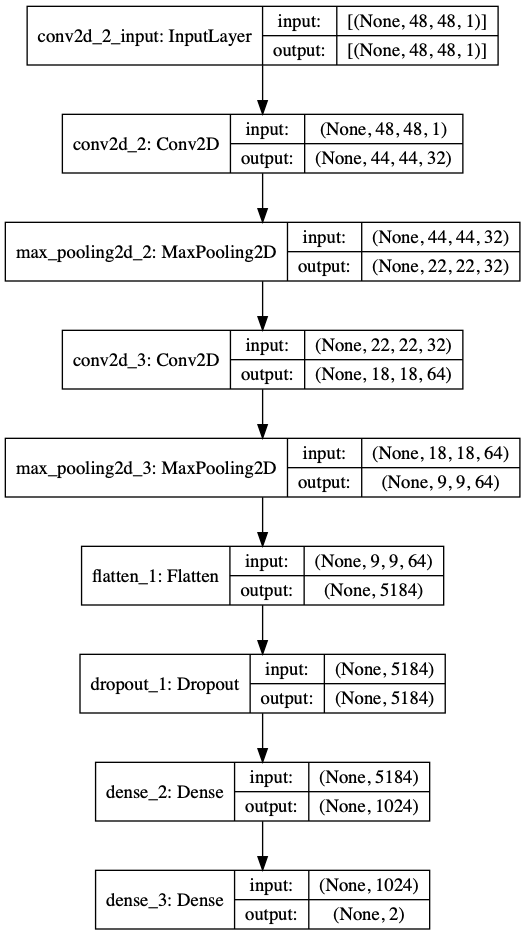

In [116]:
plot_model(cnn_calc, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [117]:
cnn_calc.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

### Training and Evaluating the Model

In [118]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)

In [119]:
test_data.batch_size

32

In [120]:
cnn_calc.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 2s 234ms/step - loss: 140.5522 - accuracy: 0.4748 - val_loss: 13.7304 - val_accuracy: 0.4545
Epoch 2/100
7/7 [==============================] - 1s 173ms/step - loss: 6.1756 - accuracy: 0.4820 - val_loss: 0.6922 - val_accuracy: 0.4545
Epoch 3/100
7/7 [==============================] - 1s 174ms/step - loss: 0.6828 - accuracy: 0.6019 - val_loss: 0.6994 - val_accuracy: 0.5000
Epoch 4/100
7/7 [==============================] - 1s 163ms/step - loss: 0.6909 - accuracy: 0.6023 - val_loss: 0.6891 - val_accuracy: 0.6515
Epoch 5/100
7/7 [==============================] - 1s 161ms/step - loss: 0.6892 - accuracy: 0.5767 - val_loss: 0.6906 - val_accuracy: 0.6212
Epoch 6/100
7/7 [==============================] - 1s 163ms/step - loss: 0.6894 - accuracy: 0.5494 - val_loss: 0.6877 - val_accuracy: 0.6515
Epoch 7/100
7/7 [==============================] - 1s 164ms/step - loss: 0.6887 - accuracy: 0.6079 - val_loss: 0.6856 - val_accuracy: 0.6364
Epoch 8/10

#### Making predictions

In [121]:
y_pred = cnn_calc.predict(test_data)

In [122]:
y_pred[0]

array([0.5218133 , 0.47818667], dtype=float32)

In [123]:
test_data.class_indices

{'B': 0, 'M': 1}

In [124]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [125]:
from sklearn.metrics import confusion_matrix, classification_report

In [126]:
confusion_matrix(expected, predicted)

array([[29,  7],
       [23,  7]])

In [127]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.56      0.81      0.66        36
           1       0.50      0.23      0.32        30

    accuracy                           0.55        66
   macro avg       0.53      0.52      0.49        66
weighted avg       0.53      0.55      0.50        66



### TRAIN AND EVALUATE MODEL FOR ARCHITECTURAL DISTORTION

In [292]:
# TRAIN AND TEST DATA FOR THE MASSES
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [293]:
archs = test_sub[(test_sub.ab_class == 'ARCH')]

In [294]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    rotation_range=180,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    validation_split=.2)

In [295]:
train_data = data_generator.flow_from_dataframe(archs, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(archs, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 183 validated image filenames belonging to 2 classes.
Found 45 validated image filenames belonging to 2 classes.


In [296]:
# create neural network
from tensorflow.keras.models import Sequential

In [297]:
cnn_archs = Sequential()

In [298]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [299]:
# add layers
cnn_archs.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [300]:
# Add a Pooling Layer
cnn_archs.add(MaxPooling2D(pool_size=(2, 2)))

In [301]:
cnn_archs.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [302]:
cnn_archs.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [303]:
cnn_archs.add(Flatten())

#### Add dense layer to reduce the number of features

In [304]:
from tensorflow.keras.layers import Dropout


In [305]:
cnn_archs.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [306]:
cnn_archs.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [307]:
cnn_archs.add(Dense(units=2, activation='softmax')) # 2 units - B/ M

In [308]:
cnn_archs.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 5184)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5184)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)            

#### Visualise the Model's Structure

In [309]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

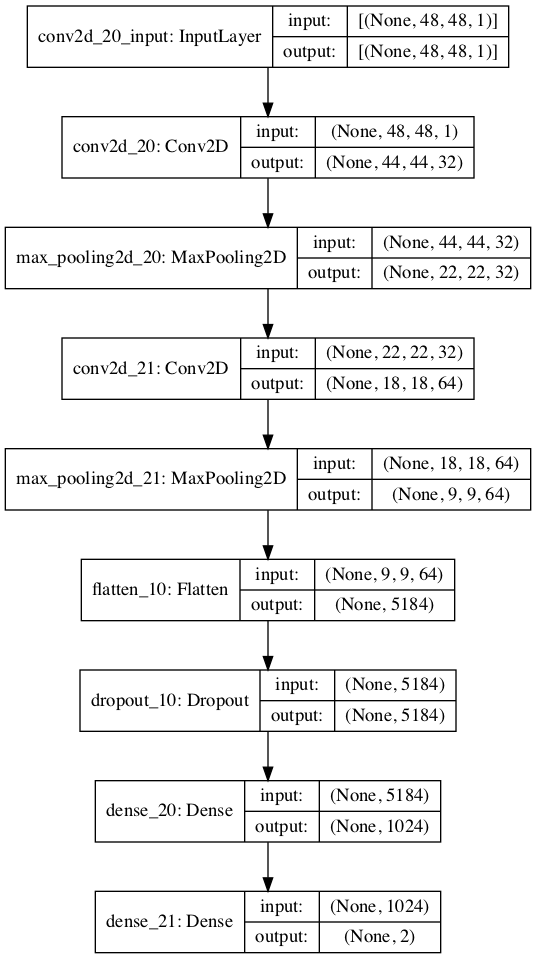

In [310]:
plot_model(cnn_archs, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [311]:
cnn_archs.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

### Training and Evaluating the Model

In [312]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [313]:
test_data.batch_size

32

In [314]:
cnn_archs.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 1s 125ms/step - loss: 56.3854 - accuracy: 0.5249 - val_loss: 1.0472 - val_accuracy: 0.8000
Epoch 2/100
6/6 [==============================] - 1s 96ms/step - loss: 1.5067 - accuracy: 0.4613 - val_loss: 0.7028 - val_accuracy: 0.6000
Epoch 3/100
6/6 [==============================] - 1s 100ms/step - loss: 0.6978 - accuracy: 0.5107 - val_loss: 0.6425 - val_accuracy: 0.7778
Epoch 4/100
6/6 [==============================] - 1s 84ms/step - loss: 0.6537 - accuracy: 0.5851 - val_loss: 0.6930 - val_accuracy: 0.7556
Epoch 5/100
6/6 [==============================] - 1s 86ms/step - loss: 0.6550 - accuracy: 0.5047 - val_loss: 0.6892 - val_accuracy: 0.8000
Epoch 6/100
6/6 [==============================] - 1s 90ms/step - loss: 0.6484 - accuracy: 0.5075 - val_loss: 0.6896 - val_accuracy: 0.8000
Epoch 7/100
6/6 [==============================] - 1s 89ms/step - loss: 0.6426 - accuracy: 0.5256 - val_loss: 0.6924 - val_accuracy: 0.7778
Epoch 8/100
6/6 [

#### Making predictions

In [315]:
y_pred = cnn_archs.predict(test_data)

In [316]:
y_pred[0]

array([0.44103795, 0.5589621 ], dtype=float32)

In [317]:
test_data.class_indices

{'B': 0, 'M': 1}

In [318]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [319]:
from sklearn.metrics import confusion_matrix, classification_report

In [320]:
confusion_matrix(expected, predicted)

array([[ 0,  9],
       [ 8, 28]])

In [321]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.76      0.78      0.77        36

    accuracy                           0.62        45
   macro avg       0.38      0.39      0.38        45
weighted avg       0.61      0.62      0.61        45



### TRAIN AND EVALUATE MODEL FOR ASYMMETRY

In [322]:
# TRAIN AND TEST DATA FOR THE ASYMMETRY
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [323]:
asym = test_sub[(test_sub.ab_class == 'ASYM')]

In [324]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    rotation_range=180,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    validation_split=.2)

In [325]:
train_data = data_generator.flow_from_dataframe(asym, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(asym, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 144 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


In [326]:
# create neural network
from tensorflow.keras.models import Sequential

In [327]:
cnn_asym = Sequential()

In [328]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [329]:
# add layers
cnn_asym.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [330]:
# Add a Pooling Layer
cnn_asym.add(MaxPooling2D(pool_size=(2, 2)))

In [331]:
cnn_asym.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [332]:
cnn_asym.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [333]:
cnn_asym.add(Flatten())

#### Add dense layer to reduce the number of features

In [334]:
from tensorflow.keras.layers import Dropout


In [335]:
cnn_asym.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [336]:
cnn_asym.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [337]:
cnn_asym.add(Dense(units=2, activation='softmax')) # 2 units - B/ M

In [338]:
cnn_asym.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 5184)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 5184)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)            

#### Visualise the Model's Structure

In [339]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

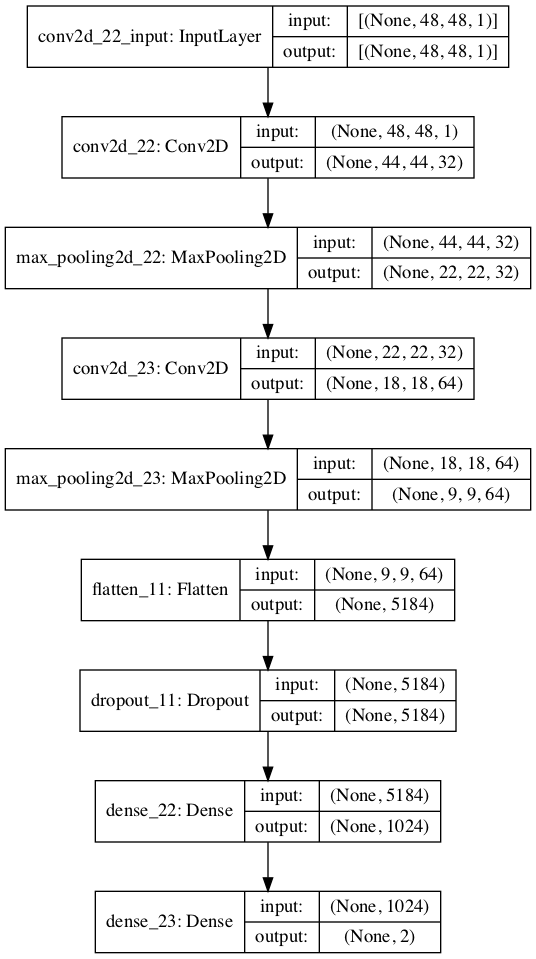

In [340]:
plot_model(cnn_asym, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [341]:
cnn_asym.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

### Training and Evaluating the Model

In [342]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [343]:
test_data.batch_size

32

In [344]:
cnn_asym.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 1s 137ms/step - loss: 143.6963 - accuracy: 0.5201 - val_loss: 11.3051 - val_accuracy: 0.6667
Epoch 2/100
5/5 [==============================] - 0s 95ms/step - loss: 7.9235 - accuracy: 0.5260 - val_loss: 2.3953 - val_accuracy: 0.6111
Epoch 3/100
5/5 [==============================] - 0s 97ms/step - loss: 1.9219 - accuracy: 0.5835 - val_loss: 0.5928 - val_accuracy: 0.5556
Epoch 4/100
5/5 [==============================] - 0s 92ms/step - loss: 0.6500 - accuracy: 0.5350 - val_loss: 0.5010 - val_accuracy: 0.6389
Epoch 5/100
5/5 [==============================] - 0s 93ms/step - loss: 0.6444 - accuracy: 0.5016 - val_loss: 0.4612 - val_accuracy: 0.6667
Epoch 6/100
5/5 [==============================] - 1s 102ms/step - loss: 0.6447 - accuracy: 0.5425 - val_loss: 0.4661 - val_accuracy: 0.6389
Epoch 7/100
5/5 [==============================] - 0s 94ms/step - loss: 1.5131 - accuracy: 0.5210 - val_loss: 0.4617 - val_accuracy: 0.6667
Epoch 8/100
5/5

#### Making predictions

In [345]:
y_pred = cnn_asym.predict(test_data)

In [347]:
y_pred[0]

array([2.1068469e-17, 1.0000000e+00], dtype=float32)

In [348]:
test_data.class_indices

{'B': 0, 'M': 1}

In [349]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [350]:
from sklearn.metrics import confusion_matrix, classification_report

In [351]:
confusion_matrix(expected, predicted)

array([[12,  0],
       [12, 12]])

In [352]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        12
           1       1.00      0.50      0.67        24

    accuracy                           0.67        36
   macro avg       0.75      0.75      0.67        36
weighted avg       0.83      0.67      0.67        36



### TRAIN AND EVALUATE MODEL FOR CALCIFICATIONS

In [353]:
# TRAIN AND TEST DATA FOR THE MASSES
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [354]:
calcifications = test_sub[(test_sub.ab_class == 'CALC')]

In [355]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    rotation_range=180,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    validation_split=.2)

In [356]:
train_data = data_generator.flow_from_dataframe(calcifications, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(calcifications, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 212 validated image filenames belonging to 2 classes.
Found 52 validated image filenames belonging to 2 classes.


In [357]:
# create neural network
from tensorflow.keras.models import Sequential

In [358]:
cnn_calc = Sequential()

In [359]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [360]:
# add layers
cnn_calc.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [361]:
# Add a Pooling Layer
cnn_calc.add(MaxPooling2D(pool_size=(2, 2)))

In [362]:
cnn_calc.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [363]:
cnn_calc.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [364]:
cnn_calc.add(Flatten())

#### Add dense layer to reduce the number of features

In [365]:
from tensorflow.keras.layers import Dropout


In [366]:
cnn_calc.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [367]:
cnn_calc.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [368]:
cnn_calc.add(Dense(units=2, activation='softmax')) # 2 units - B/ M

In [369]:
cnn_calc.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 5184)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 5184)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)            

#### Visualise the Model's Structure

In [370]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

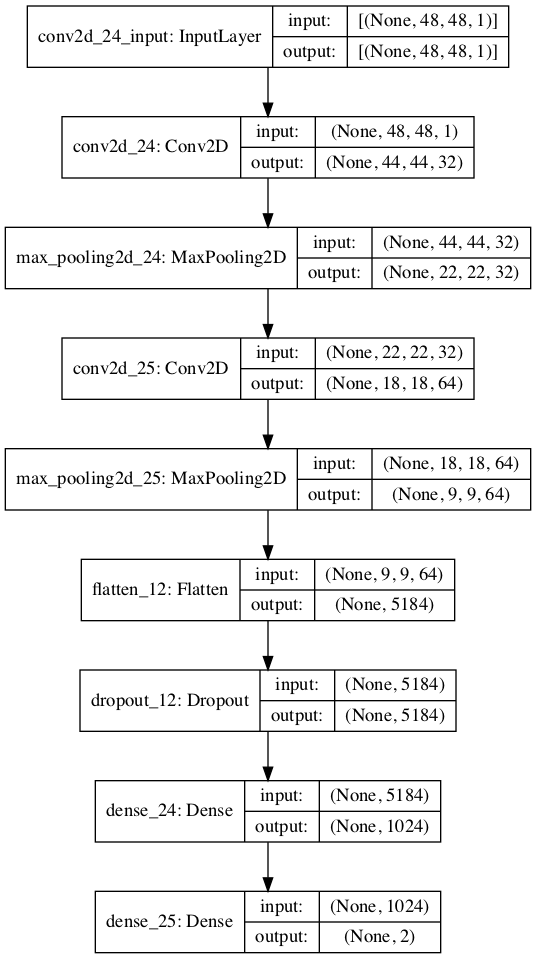

In [371]:
plot_model(cnn_calc, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [372]:
cnn_calc.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

### Training and Evaluating the Model

In [373]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [374]:
test_data.batch_size

32

In [375]:
cnn_calc.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 1s 112ms/step - loss: 112.5817 - accuracy: 0.5369 - val_loss: 3.0731 - val_accuracy: 0.3077
Epoch 2/100
7/7 [==============================] - 1s 97ms/step - loss: 1.0575 - accuracy: 0.5867 - val_loss: 0.7049 - val_accuracy: 0.3077
Epoch 3/100
7/7 [==============================] - 1s 100ms/step - loss: 0.6872 - accuracy: 0.6118 - val_loss: 0.7132 - val_accuracy: 0.3269
Epoch 4/100
7/7 [==============================] - 1s 90ms/step - loss: 0.6859 - accuracy: 0.5991 - val_loss: 0.7221 - val_accuracy: 0.3077
Epoch 5/100
7/7 [==============================] - 1s 96ms/step - loss: 0.6907 - accuracy: 0.5551 - val_loss: 0.7285 - val_accuracy: 0.3077
Epoch 6/100
7/7 [==============================] - 1s 88ms/step - loss: 0.6811 - accuracy: 0.6039 - val_loss: 0.8650 - val_accuracy: 0.3077
Epoch 7/100
7/7 [==============================] - 1s 89ms/step - loss: 0.7136 - accuracy: 0.5601 - val_loss: 0.7599 - val_accuracy: 0.3077


#### Making predictions

In [376]:
y_pred = cnn_calc.predict(test_data)

In [377]:
y_pred[0]

array([0.503424  , 0.49657604], dtype=float32)

In [378]:
test_data.class_indices

{'B': 0, 'M': 1}

In [379]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [380]:
from sklearn.metrics import confusion_matrix, classification_report

In [381]:
confusion_matrix(expected, predicted)

array([[16,  0],
       [36,  0]])

In [382]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.31      1.00      0.47        16
           1       0.00      0.00      0.00        36

    accuracy                           0.31        52
   macro avg       0.15      0.50      0.24        52
weighted avg       0.09      0.31      0.14        52



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### TRAIN AND EVALUATE MODEL FOR ALL ABNORMALITIES

In [387]:
# TRAIN AND TEST DATA FOR THE ASYMMETRY
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [388]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    rotation_range=180,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    validation_split=.2)

In [389]:
train_data = data_generator.flow_from_dataframe(test_sub, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(test_sub, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 3063 validated image filenames belonging to 3 classes.
Found 765 validated image filenames belonging to 3 classes.


In [390]:
# create neural network
from tensorflow.keras.models import Sequential

In [391]:
cnn_test_sub = Sequential()

In [392]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [393]:
# add layers
cnn_test_sub.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [394]:
# Add a Pooling Layer
cnn_test_sub.add(MaxPooling2D(pool_size=(2, 2)))

In [395]:
cnn_test_sub.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [396]:
cnn_test_sub.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [397]:
cnn_test_sub.add(Flatten())

#### Add dense layer to reduce the number of features

In [398]:
from tensorflow.keras.layers import Dropout


In [399]:
cnn_test_sub.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [400]:
cnn_test_sub.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [401]:
cnn_test_sub.add(Dense(units=3, activation='softmax')) # 2 units - B/ M / A for NORM

In [402]:
cnn_test_sub.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 5184)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 5184)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 1024)            

#### Visualise the Model's Structure

In [403]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

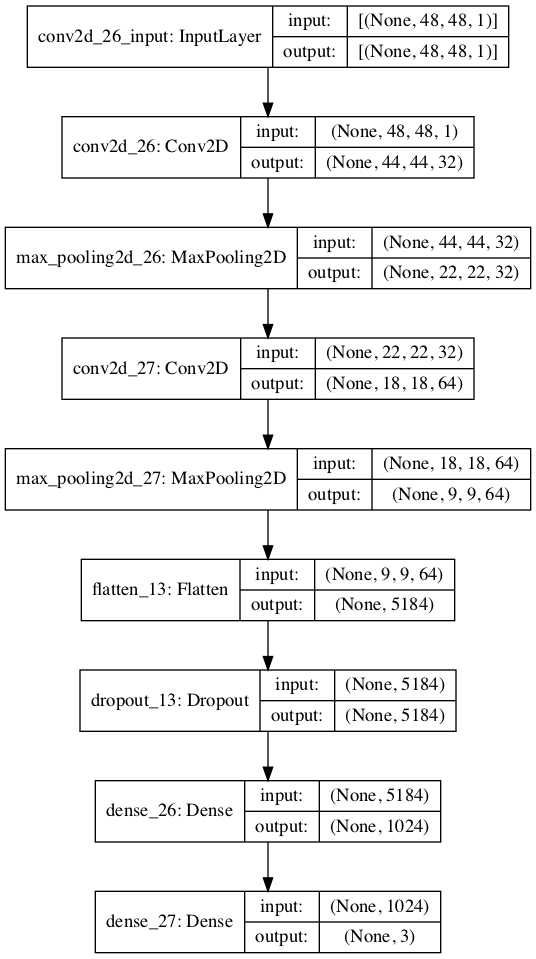

In [404]:
plot_model(cnn_test_sub, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [405]:
cnn_test_sub.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

### Training and Evaluating the Model

In [406]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [407]:
test_data.batch_size

32

In [408]:
cnn_test_sub.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
96/96 [==============================] - 9s 85ms/step - loss: 26.7258 - accuracy: 0.5298 - val_loss: 0.8569 - val_accuracy: 0.7176
Epoch 2/100
96/96 [==============================] - 8s 78ms/step - loss: 0.9310 - accuracy: 0.6286 - val_loss: 0.7965 - val_accuracy: 0.7176
Epoch 3/100
96/96 [==============================] - 7s 77ms/step - loss: 0.8961 - accuracy: 0.6459 - val_loss: 0.7951 - val_accuracy: 0.7150
Epoch 4/100
96/96 [==============================] - 8s 79ms/step - loss: 0.8980 - accuracy: 0.6438 - val_loss: 0.8018 - val_accuracy: 0.7124
Epoch 5/100
96/96 [==============================] - 8s 79ms/step - loss: 0.8942 - accuracy: 0.6489 - val_loss: 0.7965 - val_accuracy: 0.7137
Epoch 6/100
96/96 [==============================] - 8s 80ms/step - loss: 0.8929 - accuracy: 0.6451 - val_loss: 0.7911 - val_accuracy: 0.7176
Epoch 7/100
96/96 [==============================] - 8s 79ms/step - loss: 0.8909 - accuracy: 0.6505 - val_loss: 0.7937 - val_accuracy: 0.7176
Epoch

#### Making predictions

In [409]:
y_pred = cnn_test_sub.predict(test_data)

In [410]:
y_pred[0]

array([0.66449684, 0.17951238, 0.15599084], dtype=float32)

In [411]:
test_data.class_indices

{'A': 0, 'B': 1, 'M': 2}

In [412]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [413]:
from sklearn.metrics import confusion_matrix, classification_report

In [414]:
confusion_matrix(expected, predicted)

array([[549,   0,   0],
       [180,   0,   0],
       [ 36,   0,   0]])

In [415]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       549
           1       0.00      0.00      0.00       180
           2       0.00      0.00      0.00        36

    accuracy                           0.72       765
   macro avg       0.24      0.33      0.28       765
weighted avg       0.52      0.72      0.60       765



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
